In [1]:
# import relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load the datasets
customers_data = pd.read_excel(r"/Users/adityamxr/Desktop/finding-marketing-insights/data/CustomersData.xlsx")
discount_coupon = pd.read_csv(r"/Users/adityamxr/Desktop/finding-marketing-insights/data/Discount_Coupon.csv")
marketing_spend = pd.read_csv(r"/Users/adityamxr/Desktop/finding-marketing-insights/data/Marketing_Spend.csv")
online_sales = pd.read_csv(r"/Users/adityamxr/Desktop/finding-marketing-insights/data/Online_Sales.csv")
tax_amount = pd.read_excel(r"/Users/adityamxr/Desktop/finding-marketing-insights/data/Tax_amount.xlsx")

In [4]:
# verify import

dfs =[customers_data, discount_coupon, marketing_spend, online_sales, tax_amount]

for df in dfs:
    print(df.head(), '\n\n\n')
    print(df.info())

   CustomerID Gender    Location  Tenure_Months
0       17850      M     Chicago             12
1       13047      M  California             43
2       12583      M     Chicago             33
3       13748      F  California             30
4       15100      M  California             49 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     1468 non-null   int64 
 1   Gender         1468 non-null   object
 2   Location       1468 non-null   object
 3   Tenure_Months  1468 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 46.0+ KB
None
  Month Product_Category  Coupon_Code  Discount_pct
0   Jan           Apparel      SALE10            10
1   Feb           Apparel      SALE20            20
2   Mar           Apparel      SALE30            30
3   Jan          Nest-USA      ELEC10            10
4   Feb          Nest-USA   

### No nulls are present and all datatypes look appropriate, with the exception of the date features.

In [5]:
# ensure all columns in all datasets are stripped of whitespaces before converting to datetime64ns
customers_data.columns = customers_data.columns.str.strip()
discount_coupon.columns = discount_coupon.columns.str.strip()
marketing_spend.columns = marketing_spend.columns.str.strip()
online_sales.columns = online_sales.columns.str.strip()
tax_amount.columns = tax_amount.columns.str.strip()

In [6]:
# convert all date columns to datetime

# convert Transaction_Date in online_sales to datetime
online_sales['Transaction_Date'] = pd.to_datetime(online_sales['Transaction_Date'], format='%Y%m%d')

# convert Date in marketing_spend to datetime
marketing_spend['Date'] = pd.to_datetime(marketing_spend['Date'])

# convert Month in discount_coupon (from Jan, Feb, etc.) to datetime (using month names)
discount_coupon['Month'] = pd.to_datetime(discount_coupon['Month'], format='%b').dt.month

## Exploratory Data Analysis

### Invoice Amount

In [7]:
# first extract Month from online_sales
if 'Month' not in online_sales.columns:
    online_sales['Month'] = online_sales['Transaction_Date'].dt.month

# merge the relevant datasets first: online sales is the main table, so left join on that is appropriate
sales_coupon_merged = pd.merge(online_sales, discount_coupon, how ='left', on= ['Product_Category', 'Month'])
sales_full_merged = pd.merge(sales_coupon_merged, tax_amount, how='left', on= ['Product_Category'])

In [8]:
# replace missing discount_pct values with 0
sales_full_merged['Discount_pct'] = sales_full_merged['Discount_pct'].fillna(0)

In [9]:
# verify merge
sales_full_merged.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,1,ELEC10,10.0,0.10
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,1,ELEC10,10.0,0.10
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,1,OFF10,10.0,0.10
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,1,SALE10,10.0,0.18
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,1,AIO10,10.0,0.18


In [10]:
# calculate invoice value
sales_full_merged['Invoice_Value'] = (
                ((sales_full_merged['Quantity'] * sales_full_merged['Avg_Price']) *
                (1 - sales_full_merged['Discount_pct']/100) *
                (1 + sales_full_merged['GST']/100)) + sales_full_merged['Delivery_Charges']
                    )


In [11]:
# verify invoice calculation
sales_full_merged['Invoice_Value'].tail(100)

52824     40.291614
52825    112.922316
52826     77.172318
52827     62.920364
52828    255.642509
            ...    
52919     91.494910
52920     40.805639
52921    112.922316
52922    288.601820
52923    245.671456
Name: Invoice_Value, Length: 100, dtype: float64

In [12]:
sales_full_merged.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST,Invoice_Value
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,1,ELEC10,10.0,0.10,144.977339
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,1,ELEC10,10.0,0.10,144.977339
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,1,OFF10,10.0,0.10,8.346845
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,1,SALE10,10.0,0.18,85.526993
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,1,AIO10,10.0,0.18,21.376730


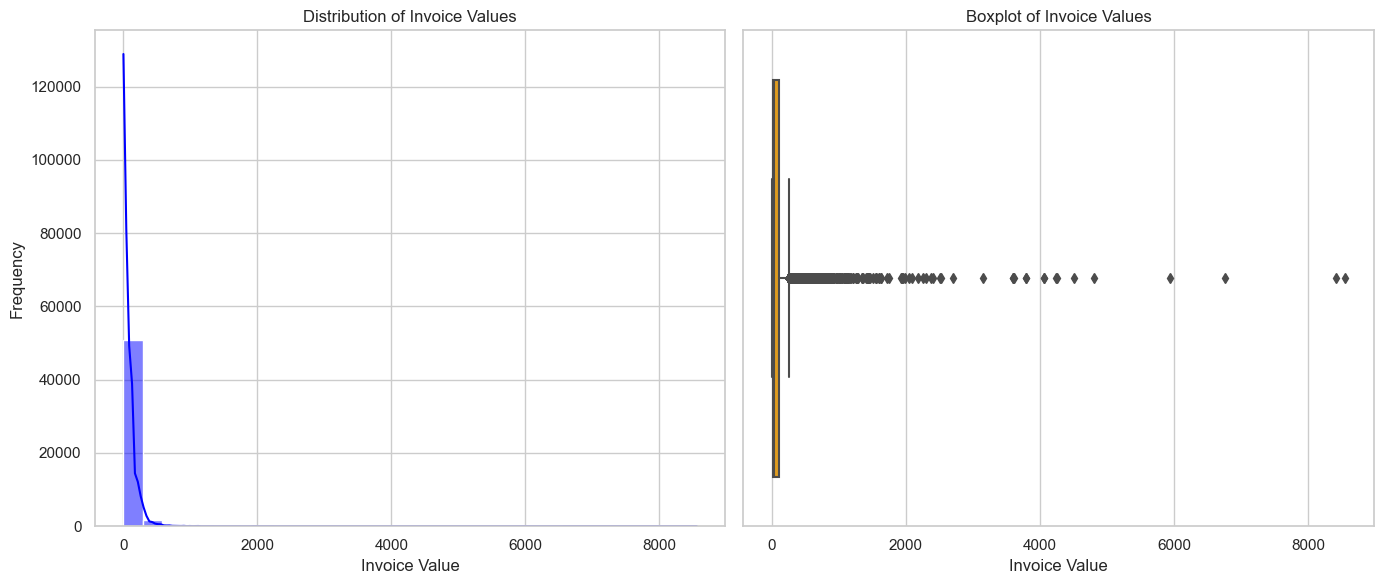

In [13]:
# set the style of seaborn
sns.set(style="whitegrid")

# create a figure to hold both plots
plt.figure(figsize=(14, 6))

# histogram to visualize the distribution of Invoice Values
plt.subplot(1, 2, 1)
sns.histplot(sales_full_merged['Invoice_Value'], bins=30, kde=True, color='blue')
plt.title('Distribution of Invoice Values')
plt.xlabel('Invoice Value')
plt.ylabel('Frequency')

# boxplot to identify outliers in Invoice Values
plt.subplot(1, 2, 2)
sns.boxplot(x=sales_full_merged['Invoice_Value'], color='orange')
plt.title('Boxplot of Invoice Values')
plt.xlabel('Invoice Value')

# show both plots
plt.tight_layout()
plt.show()